In [ ]:
# dataframet hämtas från Del 2 av rapporten
%store -r

import pandas as pd
df1 = df.drop(columns=["ap_hi", "ap_lo", "height", "weight", "BMI", "id"])
df2 = df.drop(columns=["Obesity", "HBP", "height", "weight", "id"])

# one-hot encoding på vissa av variablerna
df1 = pd.get_dummies(df1, columns=["Obesity", "HBP", "gender"])
df2 = pd.get_dummies(df2, columns=["gender"])


## Modellering
Två nya dataset skapades, baserade på det ursprungliga datasetet *df*:
- Dataset 1 (**df1**), där prediktorerna *ap_hi*, *ap_lo*, *height*, *weight* och *BMI* tagits bort. Kvar fanns blodtryckskategori och BMI-kategori, som ett gemensamt mått på längd och vikt. I detta dataset gjordes *one-hot-encoding* på BMI, blodtryckskategori och kön. Blodtryckskategorerna och BMI-kategorierna kunde visserligen rangordnas inbördes, men det fanns inget *linjärt* inbördes samband, och då var det bättre att ersätta förekomsten av varje kategori med 0 respektive 1.

- Dataset 2 (**df2**), där prediktorerna *Obesity*, *HBP*, *height* och *weight* tagits bort. Kvar fanns *ap_hi*, *ap_lo* och *BMI* kvar, som mått på blodtryck, längd och vikt. Här gjordes one-hot-encoding på kön, då det inte förekommer någon ordningsrelation mellan könen.

  Även id-kolumnen togs bort i båda dataseten, då detta bara var ett identifikationsnummer och inte påverkade förekomsten av hjärt-kärlsjukdom.

Vart och ett av de två dataseten delades därefter upp i tre delar: *train* (60%), *validation* (20%) och *test* (20%). Detta gjordes genom att först dela upp i train/test, med förhållandet 60/40, och därefter dela upp test-delen ytterligare, i test/val, med inbördes förhållandet 50/50. Detta gav en total fördelning på 60/20/20. Med ett så stort dataset gjordes bedömningen att 60% räckte för träning, vilket annars kanske varit i lägsta laget.

Alla dataset som härstammade från **Dataset 1** namngavs med en 1:a, och alla från **Dataset 2** namngavs med en 2:a i namnet. Denna princip behölls genom återstoden av rapporten.

Eftersom det var förekomsten av hjärt-kärlsjukdomar som skulle förutspås, var det kolumnen *cardio* som utgjorde responsvariabel, alltså y. Övriga kolumner var prediktorer och kallades X.

In [6]:
from sklearn.model_selection import train_test_split

X1, y1 = df1.drop("cardio", axis=1), df1["cardio"]
X2, y2 = df2.drop("cardio", axis=1), df2["cardio"]

# Uppdelning i train/test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=42)

# Test-seten delades upp i val/test
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_test, y1_test, test_size=0.5, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_test, y2_test, test_size=0.5, random_state=42)

# Storleken på alla 12 dataset kontrollerades
print(X1_train.shape, X1_val.shape, X1_test.shape, y1_train.shape, y1_val.shape, y1_test.shape)
print(X2_train.shape, X2_val.shape, X2_test.shape, y2_train.shape, y2_val.shape, y2_test.shape)

(40626, 18) (13542, 18) (13542, 18) (40626,) (13542,) (13542,)
(40626, 11) (13542, 11) (13542, 11) (40626,) (13542,) (13542,)


Alla dataset skalades med *StandardScaler*, det vill säga träningsseten fick medelvärde 0 och standardavvikelse 1, medan validerings- och testseten skalades om enligt samma skala. Därefter gjordes även en normalisering med hjälp av en *MinMaxScaler*. Det bedömdes att denna kunde användas, då ingen av prediktorerna hade enstaka värden som skiljde sig kraftigt från övriga.

För att hålla reda på namngivningen av seten gavs ett skalat set prefixet s-, och ett normaliserat set prefixet n-. Exempelvis skulle beteckningen **snX2-train** tolkas som ett skalat och normailserat träningsset från **Dataset 2**.

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
sX1_train = scaler.fit_transform(X1_train)
sX1_val = scaler.transform(X1_val)
sX1_test = scaler.transform(X1_test)

sX2_train = scaler.fit_transform(X2_train)
sX2_val = scaler.transform(X2_val)
sX2_test = scaler.transform(X2_test)

scaler = MinMaxScaler()
scaler.fit(sX1_train)
snX1_train=scaler.transform(sX1_train)
snX1_test=scaler.transform(sX1_test)
snX1_val=scaler.transform(sX1_val)

scaler.fit(sX2_train)
snX2_train=scaler.transform(sX2_train)
snX2_test=scaler.transform(sX2_test)
snX2_val=scaler.transform(sX2_val)

## Train/test-modeller
Därefter följde det kanske viktigaste - att välja vilka maskininlärningsmodeller som skulle testas för att förutspå hjärtsjukdomar. Av tids- och utrymmesskäl valdes endast tre modeller ut: *KNearestNeighbors*, *LogisticRegression* och *Support Vector Machine*. Alla tre lämpar sig bra då man endast ska göra en klassificering mellan två olika värden, i detta fall **0** (ingen hjärt-kärlsjukdom) och **1** (hjärt-kärlsjukdom).

För *KNN* varierades antalet *nearest neighbors* att utgå ifrån, från 1 upp till 30. Detta gjordes med hjälp av *GridSearchCV* och *Pipeline*. I likhet med de andra modellerna kördes denna modell både för datasetet df1 och df2.

För den logistiska regressionen (nedan förkortat *LOG*) användes penalty-varianten *elasticnet*, vilket innebar att *l1-ratio* (hur stor andel av penaltyn som ska utgöras av l1/lasso, i förhållande till L2/ridge) fick varieras från 0 till 1 (i 20 steg) med hjälp av GridSearchCV. Att även variera max antal iterationer hade tagit för lång tid, så denna sattes till 1000.

Slutligen, när det gällde Support Vector Machine (nedan förkortat *SVM*), användes Soft Margin Classifier-varianten (SVC). Eftersom både *C*-värdet (som anger hur hårda/förlåtande gränserna ska vara) och *gamma*-värdet (som är parametern för den rbf-kernel som används) varierades, blev det för tidskrävande att testa för många värden. Möjliga *C*-värden sattes därför till 0.1, 1 och 10, medan gamma-vardena sattes till 1, 0.1 och 0.01, vilket gav sammanlagt 3x3 = 9 olika kombinationer.

Först definierades funktioner för de valda modellerna. Funktionerna returnerar själva klassifieraren, samt värden på de estimatorer som visade sig vara bäst:

In [9]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

def KNN(xtr,ytr):
    # KNearestNeighbor, antal neigbors varieras fråmn 1 till 30
    pipe_KNN=Pipeline([("scaler", scaler), ("knn", KNeighborsClassifier())])
    param_grid_KNN = {"knn__n_neighbors": list(range(1,30))}
    classifier_KNN = GridSearchCV(estimator=pipe_KNN, param_grid=param_grid_KNN, scoring="accuracy")
    classifier_KNN.fit(xtr, ytr)
    return classifier_KNN, classifier_KNN.best_estimator_.get_params()

def LOG(xtr,ytr):
    # Logistisk regression, l1ratio varieras från 0 till 1
    pipe_log=Pipeline([("scaler", scaler), ("log", LogisticRegression(solver="saga", max_iter=1000, penalty="elasticnet"))])
    param_grid_log={"log__l1_ratio": np.linspace(0, 1, 21)}
    classifier_log = GridSearchCV(estimator=pipe_log, param_grid=param_grid_log, scoring="accuracy")
    classifier_log.fit(xtr, ytr)
    return classifier_log, classifier_log.best_estimator_.get_params()

def SVM(xtr,ytr):
    # Support Vector Machine, C varieras mellan 0.1, 1 och 10, gamma varieras mellan 1, 0.1 och 0.01
    param_grid_SVM = {"C":[0.1, 1, 10], "gamma":[1, 0.1, 0.01], "kernel": ["rbf"]}
    classifier_SVM = GridSearchCV(SVC(), param_grid_SVM, refit=True, verbose=3)
    classifier_SVM.fit(xtr, ytr)
    return classifier_SVM, classifier_SVM.best_estimator_.get_params()
    

Först kördes alla tre modellerna för det första train-setet (*snX1_train*):

In [10]:
classifier_KNN_1, params_KNN_1 = KNN(snX1_train,y1_train)
classifier_LOG_1, params_LOG_1 = LOG(snX1_train,y1_train)
classifier_SVM_1, params_SVM_1 = SVM(snX1_train,y1_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.704 total time=  58.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.695 total time=  58.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.698 total time=  57.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.702 total time=  57.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.699 total time= 1.0min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.698 total time=  59.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.686 total time=  55.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.689 total time=  56.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.691 total time=  55.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.687 total time=  53.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.694 total time=  58.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;,

Och därefter kördes samma modeller igen, men nu med det andra train-setet (*snX2_train*)

In [11]:
classifier_KNN_2, params_KNN_2 = KNN(snX2_train,y2_train)
classifier_LOG_2, params_LOG_2 = LOG(snX2_train,y2_train)
classifier_SVM_2, params_SVM_2 = SVM(snX2_train,y2_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.733 total time=  40.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.727 total time=  40.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.729 total time=  41.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.724 total time=  41.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.726 total time=  41.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.726 total time=  46.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.720 total time=  46.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.721 total time=  46.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.719 total time=  44.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.722 total time=  43.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.697 total time=  49.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;,

När modellerna hade tränats testades de på valideringsseten (*snX1_val* respektive *snX2_val*) för att se hur många personer de lyckats klassificera korrekt. Resultaten presenterades med hjälp av en *Confusion Matrix*:

In [ ]:
def Conf_Matr_Disp(clf,xval,yval):
    # denna funktion skriver ut classification report och confusion matrix
    y_pred=clf.predict(xval)
    print(classification_report(yval, y_pred))
    cm=confusion_matrix(yval, y_pred)
    ConfusionMatrixDisplay(cm).plot()

Eftersom sex olika tester skulle köras (3 modeller x 2 dataset), redovisas en i taget, med tillhörande analys av resultat och parametrar.

I ConfusionMatrixen önskades höga värden längs huvuddiagonalen, vilket skulle innebära att såväl många *med* som *utan* hjärt-kärlsjukdomar klassificerats rätt. Med tanke på att det handlade om att identifiera sjukdom var kanske *recall*-värdet dock det allra viktigaste; att identifiera så många personer i riskgrupp som möjligt är viktigare än det faktum att det kan bli många "falsklarm" (friska personer som felaktigt klassificeras som sjuka). Det var med andra ord önskvärt med inga "False negatives", eller åtminstone så få som möjligt. Detta togs i beaktande då modellerna jämfördes.

## KNearestNeighbor, Dataset 1

              precision    recall  f1-score   support

           0       0.68      0.78      0.72      6878
           1       0.73      0.62      0.67      6664

    accuracy                           0.70     13542
   macro avg       0.70      0.70      0.70     13542
weighted avg       0.70      0.70      0.70     13542



{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=28))],
 'transform_input': None,
 'verbose': False,
 'scaler': MinMaxScaler(),
 'knn': KNeighborsClassifier(n_neighbors=28),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 28,
 'knn__p': 2,
 'knn__weights': 'uniform'}

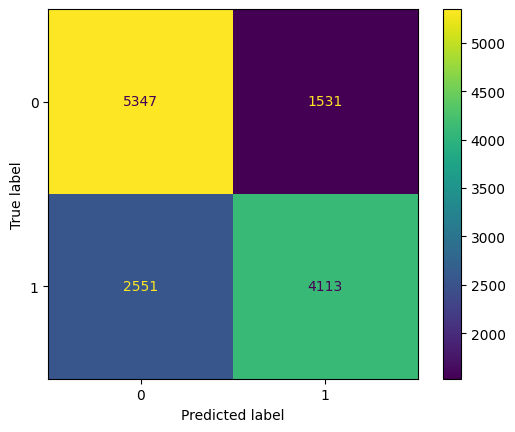

In [13]:
Conf_Matr_Disp(classifier_KNN_1, snX1_val, y1_val)
params_KNN_1

## Logistic Regression, Dataset 1

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      6878
           1       0.74      0.62      0.68      6664

    accuracy                           0.71     13542
   macro avg       0.71      0.71      0.70     13542
weighted avg       0.71      0.71      0.70     13542



{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('log',
   LogisticRegression(l1_ratio=np.float64(0.8500000000000001), max_iter=1000,
                      penalty='elasticnet', solver='saga'))],
 'transform_input': None,
 'verbose': False,
 'scaler': MinMaxScaler(),
 'log': LogisticRegression(l1_ratio=np.float64(0.8500000000000001), max_iter=1000,
                    penalty='elasticnet', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': np.float64(0.8500000000000001),
 'log__max_iter': 1000,
 'log__multi_class': 'deprecated',
 'log__n_jobs': None,
 'log__penalty': 'elasticnet',
 'log__random_state': None,
 'log__solver': 'saga',
 'log__tol': 0.0001,
 'log__verbose': 0,
 'log__warm_start': False}

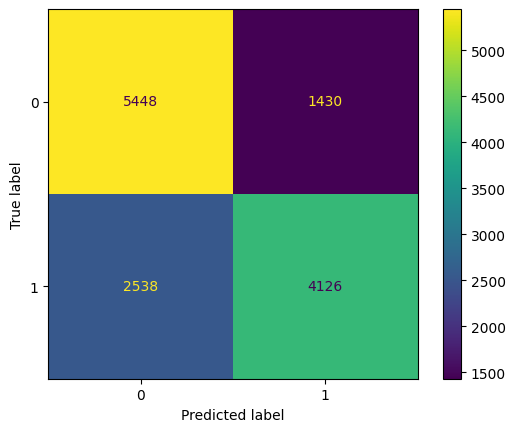

In [14]:
Conf_Matr_Disp(classifier_LOG_1, snX1_val, y1_val)
params_LOG_1

## Support Vector Machine, Dataset 1

              precision    recall  f1-score   support

           0       0.68      0.79      0.73      6878
           1       0.74      0.61      0.67      6664

    accuracy                           0.70     13542
   macro avg       0.71      0.70      0.70     13542
weighted avg       0.71      0.70      0.70     13542



{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

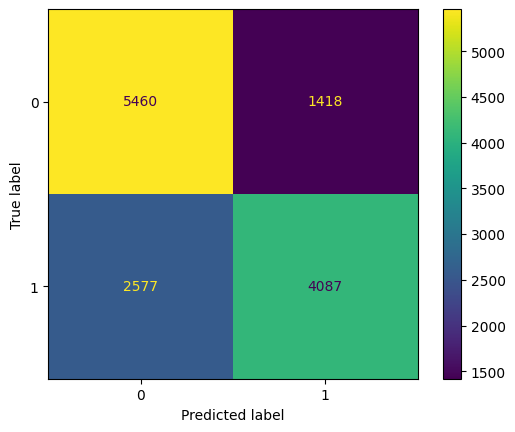

In [15]:
Conf_Matr_Disp(classifier_SVM_1, snX1_val, y1_val)
params_SVM_1

## KNearestNeighbor, Dataset 2

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6878
           1       0.74      0.68      0.71      6664

    accuracy                           0.72     13542
   macro avg       0.73      0.72      0.72     13542
weighted avg       0.73      0.72      0.72     13542



{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=29))],
 'transform_input': None,
 'verbose': False,
 'scaler': MinMaxScaler(),
 'knn': KNeighborsClassifier(n_neighbors=29),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 29,
 'knn__p': 2,
 'knn__weights': 'uniform'}

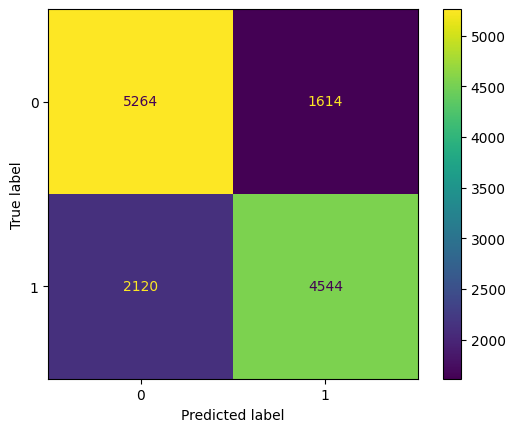

In [16]:
Conf_Matr_Disp(classifier_KNN_2, snX2_val, y2_val)
params_KNN_2

## Logistic Regression, Dataset 2

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6878
           1       0.75      0.67      0.71      6664

    accuracy                           0.73     13542
   macro avg       0.73      0.73      0.73     13542
weighted avg       0.73      0.73      0.73     13542



{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('log',
   LogisticRegression(l1_ratio=np.float64(0.5), max_iter=1000,
                      penalty='elasticnet', solver='saga'))],
 'transform_input': None,
 'verbose': False,
 'scaler': MinMaxScaler(),
 'log': LogisticRegression(l1_ratio=np.float64(0.5), max_iter=1000,
                    penalty='elasticnet', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': np.float64(0.5),
 'log__max_iter': 1000,
 'log__multi_class': 'deprecated',
 'log__n_jobs': None,
 'log__penalty': 'elasticnet',
 'log__random_state': None,
 'log__solver': 'saga',
 'log__tol': 0.0001,
 'log__verbose': 0,
 'log__warm_start': False}

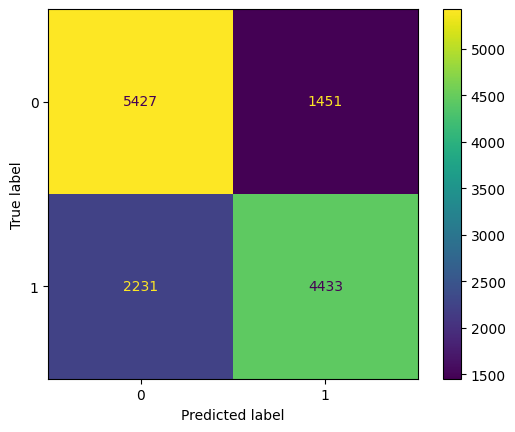

In [17]:
Conf_Matr_Disp(classifier_LOG_2, snX2_val, y2_val)
params_LOG_2

## Support Vector Machine, Dataset 2

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6878
           1       0.75      0.68      0.71      6664

    accuracy                           0.73     13542
   macro avg       0.73      0.73      0.73     13542
weighted avg       0.73      0.73      0.73     13542



{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

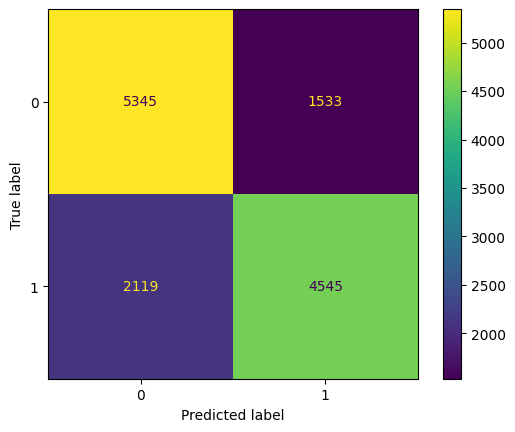

In [18]:
Conf_Matr_Disp(classifier_SVM_2, snX2_val, y2_val)
params_SVM_2

## Jämförelse av modellerna

Det konstaterades att modellkörningarna på Dataset 2 genomgående fick betydligt bättre värden än på Dataset 1, i synnerhet *recall*-värdena på variabeln 1, som ju var det som prioriterades i första hand. För Dataset 1 låg *recall*-värdena på 0.61-0.62, medan de låg på 0.67-0.68 för Dataset 2. Antalet personer som blev *False negative*-klassificerade var alltså betydligt lägre i Dataset 2 (ca 2100-2200, jämfört med 2500-2600 för Dataset 1). Som tidigare konstaterats var det absolut viktigaste att minimera antalet *False negatives*, det är mycket olyckligt om sjuka människor får frisk-diagnos.

Dataset 1 var dock något bättre på att plocka ut *True negatives*, men det ansågs mindre viktigt i sammanhanget. De totala *accuracy*-värdena var för övrigt högre i Dataset 2 än i Dataset 1 i samtliga fall.

**Därför togs beslutet att enbart gå vidare med Dataset 2 i *Voting Classifier*-analysen.**

En inbördes jämförelse av de tre modellerna för Dataset 2 gav inga stora skillnader, vare sig på *accuracy* eller *recall*, och det var svårt att dra någon säker slutsats om vilken som egentligen var bäst. Förhoppningen var att en sammanställning med *Voting Classifier* skulle kunna ge något bättre resultat.

## Voting Classifier

Innan en körning med *Voting Classifier* kunde göras, samlades de bästa värdena på hyperparametrarna in från de olika modellerna:
- **KNearestNeighbor**: *Antal nearest neighbors*: 29
- **Logistic Regression**: *l1-ratio*: 0.50
- **Support Vector Machine**: *C-värde*: 1, *gamma-värde*: 1

Därefter kördes *Voting Classifier* på Dataset 2, där de tre modellerna alltså fick rösta om klassifieringen. 

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# 3 olika classifiers testas
clf1=LogisticRegression(l1_ratio=0.5, penalty="elasticnet", solver="saga")
clf2=KNeighborsClassifier(n_neighbors=29)
clf3=SVC(gamma=1, C=1, kernel="rbf")

eclf1=VotingClassifier(estimators=[("log",clf1), ("knn",clf2), ("svc",clf3)],voting="hard")
eclf1.fit(snX2_train, y2_train)

y2_pred = eclf1.predict(snX2_val)

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6878
           1       0.75      0.68      0.71      6664

    accuracy                           0.73     13542
   macro avg       0.73      0.73      0.73     13542
weighted avg       0.73      0.73      0.73     13542



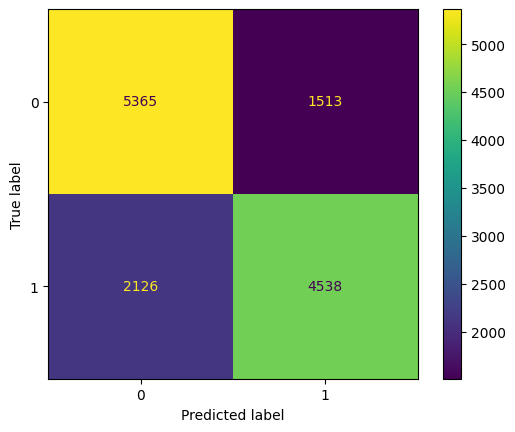

In [20]:
cm=confusion_matrix(y2_val, y2_pred)
print(classification_report(y2_val, y2_pred))
ConfusionMatrixDisplay(cm).plot()

Värdena från *Voting Classifier* skilde sig inte nämnnärt från de tre ursprungliga modellerna, det blev ungefär samma på såväl *recall* som *accuracy*.

Därför togs beslutet att välja **Support Vector Machine** på **Dataset 2** som den slutgiltiga modellen.

Vilken modell som helst kunde egentligen ha valts, men det var trots allt *Support Vector Machine* som hade allra minst antal felklassificerade sjuka människor, och det fick fälla avgörandet.

För att utvärdera den valda modellen, testades den på den ännu "oanvända" delen av **Dataset 2**, nämligen *X2_test* (hittills hade modellerna tränats på *X2_train* och validerats på *X2_test*). Därmed kunde nu träningen göras på både *X2_train* och *X2_val*, så dessa dataset slogs ihop till *X2_trainval* och skalades om.

In [ ]:
# train- och val-seten slås ihop till ett gemensamt träningsset, trainval
X2_trainval = pd.concat([X2_train, X2_val])
y2_trainval = pd.concat([y2_train, y2_val])

scaler = StandardScaler()
sX2_trainval = scaler.fit_transform(X2_trainval)
sX2_test = scaler.transform(X2_test)

scaler = MinMaxScaler()
scaler.fit(sX2_train)
snX2_trainval=scaler.transform(sX2_trainval)
snX2_test=scaler.transform(sX2_test)



När den "vinnande" SVM-modellen nu testades på *snX2_test* användes de parametrar (C=1, gamma=1) som fått bäst resultat vid den utsprungliga test/val-körningen:

In [ ]:
# Classifier_SVM_Final = slutgilitiga modellen
Classifier_SVM_Final = SVC(kernel="rbf", C=1, gamma=1)
Classifier_SVM_Final.fit(snX2_trainval, y2_trainval)

y2_pred_Final = Classifier_SVM_Final.predict(snX2_test)

Resultatet av körningen presenterades med en *Classification report* och en *Confusion Matrix*:

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      6831
           1       0.77      0.68      0.72      6711

    accuracy                           0.74     13542
   macro avg       0.74      0.74      0.74     13542
weighted avg       0.74      0.74      0.74     13542



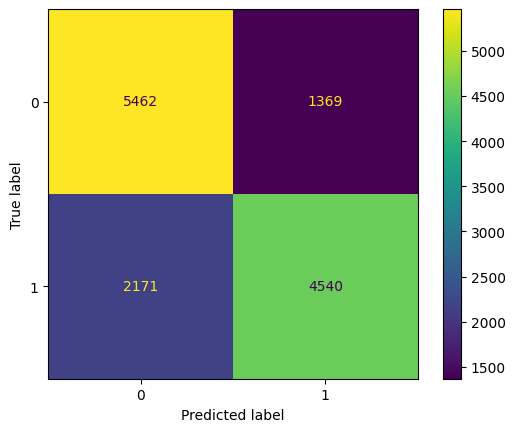

In [24]:
Conf_Matr_Disp(Classifier_SVM_Final, snX2_test, y2_test)


Resultatet blev ungefär i linje med de tidigare körningarna: Recall-värde på 0.68 (sammanlagt 2171 felklassificerade sjuka), och accuracy på 0.74. Det kan knappast betraktas som bra, det krävs större andel korrekt klassificerade sjuka för att man ska kunna anse att modellen gör ett bra jobb. Men det visar också att den här typen av sjukdomar är svåra att förutsäga. Modellen har trots allt gjort ett bra jobb när det gäller att friskförklara verkligt friska personer.

Det kan också konstateras att **Dataframe 2**, som behöll de ursrungliga värdena på blodtryck och BMI, gjorde att det blev enklare att klassificera personerna, än om man skulle ha utgått från **Dataframe 1** med fler kategoriska variabler.